In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
d = pd.read_csv('ValsCoordsPanoramaAlternas3.csv')

In [3]:
print("Size :", d.size)
print("Shape:", d.shape)
print(d.head())

Size : 1629744
Shape: (203718, 8)
   ID           Species  code  longitude  latitude  bio_10  bio_11  bio_12
0   1  Adiantum_lucidum     1     -80.86      8.43     242     228    3183
1   2  Adiantum_lucidum     1     -80.61      7.74     270     254    1832
2   3  Adiantum_lucidum     1     -80.37      8.60     272     253    2491
3   4  Adiantum_lucidum     1     -80.14      8.63     238     222    2893
4   5  Adiantum_lucidum     1     -80.10      9.15     272     257    3301


In [4]:
names = set(d.loc[:, 'Species'])

In [5]:
print("Number of species: ", len(names))

Number of species:  187


In [6]:
coord_folder = 'HexagonsCoordsVars/'
nubes = pd.DataFrame()
for i in range(3000, 136000, 1000):
    try:
        filename = coord_folder + 'vars_coords_' + str(i) + '.csv'
        tmp = pd.read_csv(filename)
        nubes = nubes.append(tmp)
    except:
        pass

In [7]:
print(nubes.head())

   UniqueID  SiteID  Longitude   Latitude   puntos10    puntos11    puntos12
0         4     594     -80.75  82.834936  -3.800000 -392.799988   70.000000
1         5     595     -79.25  82.834936 -21.650000 -406.799988  112.300003
2         6     596     -77.75  82.834936 -17.049999 -394.049988  103.750000
3         7     597     -76.25  82.834936 -29.200001 -401.200012  135.300003
4        11     698     -86.00  82.401924   0.800000 -404.350006   64.900002


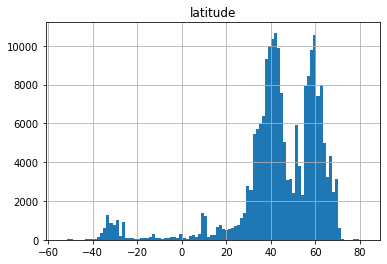

In [8]:
latitude_hist = d.hist(column='latitude', bins=100)

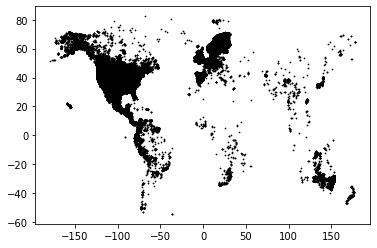

In [9]:
plt.scatter(d.longitude, d.latitude, color='black', s=0.5)